In [1]:
import numpy as np
import librosa
import os
import glob
import pandas as pd
import pickle
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
from librosa.display import waveplot
import matplotlib.pyplot as plt
import PIL.Image

In [2]:
audio = '/home/ubuntu/UrbanSound8K/audio'
folders = ["fold1","fold2","fold3","fold4","fold5","fold6","fold7","fold8","fold9","fold10"]

In [3]:
def get_audio_features(parent_dir, sub_dirs, file_ext="*.wav"):
    features = np.empty((0,80))
    labels, folds = [], []
    for idx, sub_dir in enumerate(sub_dirs):
        print(f"Processing {sub_dir}...")
        for file in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            librosa_load, librosa_sampling_rate = librosa.load(file, mono=True)
            stft = np.abs(librosa.stft(librosa_load))
            mfcc_mean = np.mean(librosa.feature.mfcc(y=librosa_load, sr=librosa_sampling_rate, n_mfcc=13).T,axis=0)
            mfcc_std = np.std(librosa.feature.mfcc(y=librosa_load, sr=librosa_sampling_rate, n_mfcc=13).T,axis=0)
            contrast_mean = np.mean(librosa.feature.spectral_contrast(S=stft, sr=librosa_sampling_rate).T,axis=0)
            contrast_std = np.std(librosa.feature.spectral_contrast(S=stft, sr=librosa_sampling_rate).T,axis=0)
            chroma_mean = np.mean(librosa.feature.chroma_stft(S=stft, sr=librosa_sampling_rate).T,axis=0)
            chroma_std = np.std(librosa.feature.chroma_stft(S=stft, sr=librosa_sampling_rate).T,axis=0)
            rolloff_mean = np.mean(librosa.feature.spectral_rolloff(S=stft, sr=librosa_sampling_rate).T,axis=0)
            rolloff_std = np.std(librosa.feature.spectral_rolloff(S=stft, sr=librosa_sampling_rate).T,axis=0)
            feature_cols = np.hstack([mfcc_mean, mfcc_std, contrast_mean, contrast_std, 
                                      chroma_mean, chroma_std, rolloff_mean, rolloff_std])
            features = np.vstack((features, feature_cols))
            target = (file.split('/')[6].split('-')[1])
            labels.append(int(target))
            folds.append(sub_dir)
    return features, labels, folds

In [5]:
%%capture
features, labels, folds = get_audio_features(audio, folders)

## For Pytorch

In [3]:
def get_nn_features(parent_dir,sub_dirs,file_ext="*.wav"):
    cgrams = []
    labels = []
    folds = []
    i = 0
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            lib_load, sample_rate = librosa.load(fn)
            label = fn.split('fold')[1].split('-')[1]
            labels.append(label)
            folds.append(sub_dir)
            stft = np.abs(librosa.stft(lib_load))
            cgram = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
            librosa.display.specshow(cgram)
            plt.savefig(fn + '.png', dpi=10)
#             rgba_image = PIL.Image.open(fn + '.png')
#             rgb_image = rgba_image.convert('RGB')
#             cgrams.append(np.array(rgb_image))
            i +=1
            print(f"file {i} processed")
    return cgrams, labels, folds

file 1 processed
file 2 processed
file 3 processed
file 4 processed
file 5 processed
file 6 processed
file 7 processed
file 8 processed
file 9 processed
file 10 processed
file 11 processed
file 12 processed
file 13 processed
file 14 processed
file 15 processed
file 16 processed
file 17 processed
file 18 processed
file 19 processed
file 20 processed
file 21 processed
file 22 processed
file 23 processed
file 24 processed
file 25 processed
file 26 processed
file 27 processed
file 28 processed
file 29 processed
file 30 processed
file 31 processed
file 32 processed
file 33 processed
file 34 processed
file 35 processed
file 36 processed
file 37 processed
file 38 processed
file 39 processed
file 40 processed
file 41 processed
file 42 processed
file 43 processed
file 44 processed
file 45 processed
file 46 processed
file 47 processed
file 48 processed
file 49 processed
file 50 processed
file 51 processed
file 52 processed
file 53 processed
file 54 processed
file 55 processed
file 56 processed
f

/home/ubuntu/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


file 100 processed
file 101 processed
file 102 processed
file 103 processed
file 104 processed
file 105 processed
file 106 processed
file 107 processed
file 108 processed
file 109 processed
file 110 processed
file 111 processed
file 112 processed
file 113 processed
file 114 processed
file 115 processed
file 116 processed
file 117 processed
file 118 processed
file 119 processed
file 120 processed
file 121 processed
file 122 processed
file 123 processed
file 124 processed
file 125 processed
file 126 processed
file 127 processed
file 128 processed
file 129 processed
file 130 processed
file 131 processed
file 132 processed
file 133 processed
file 134 processed
file 135 processed
file 136 processed
file 137 processed
file 138 processed
file 139 processed
file 140 processed
file 141 processed
file 142 processed
file 143 processed
file 144 processed
file 145 processed
file 146 processed
file 147 processed
file 148 processed
file 149 processed
file 150 processed
file 151 processed
file 152 pro

/home/ubuntu/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


file 334 processed
file 335 processed
file 336 processed
file 337 processed
file 338 processed
file 339 processed
file 340 processed
file 341 processed
file 342 processed
file 343 processed
file 344 processed
file 345 processed
file 346 processed
file 347 processed
file 348 processed
file 349 processed
file 350 processed
file 351 processed
file 352 processed
file 353 processed
file 354 processed
file 355 processed
file 356 processed
file 357 processed
file 358 processed
file 359 processed
file 360 processed
file 361 processed
file 362 processed
file 363 processed
file 364 processed
file 365 processed
file 366 processed
file 367 processed
file 368 processed
file 369 processed
file 370 processed
file 371 processed
file 372 processed
file 373 processed
file 374 processed
file 375 processed
file 376 processed
file 377 processed
file 378 processed
file 379 processed
file 380 processed
file 381 processed
file 382 processed
file 383 processed
file 384 processed
file 385 processed
file 386 pro

/home/ubuntu/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


file 508 processed
file 509 processed
file 510 processed
file 511 processed
file 512 processed
file 513 processed
file 514 processed
file 515 processed
file 516 processed
file 517 processed
file 518 processed
file 519 processed
file 520 processed
file 521 processed
file 522 processed
file 523 processed
file 524 processed
file 525 processed
file 526 processed
file 527 processed
file 528 processed
file 529 processed
file 530 processed
file 531 processed
file 532 processed
file 533 processed
file 534 processed
file 535 processed
file 536 processed
file 537 processed
file 538 processed
file 539 processed
file 540 processed
file 541 processed
file 542 processed
file 543 processed
file 544 processed
file 545 processed
file 546 processed
file 547 processed
file 548 processed
file 549 processed
file 550 processed
file 551 processed
file 552 processed
file 553 processed
file 554 processed
file 555 processed
file 556 processed
file 557 processed
file 558 processed
file 559 processed
file 560 pro

file 940 processed
file 941 processed
file 942 processed
file 943 processed
file 944 processed
file 945 processed
file 946 processed
file 947 processed
file 948 processed
file 949 processed
file 950 processed
file 951 processed
file 952 processed
file 953 processed
file 954 processed
file 955 processed
file 956 processed
file 957 processed
file 958 processed
file 959 processed
file 960 processed
file 961 processed
file 962 processed
file 963 processed
file 964 processed
file 965 processed
file 966 processed
file 967 processed
file 968 processed
file 969 processed
file 970 processed
file 971 processed
file 972 processed
file 973 processed
file 974 processed
file 975 processed
file 976 processed
file 977 processed
file 978 processed
file 979 processed
file 980 processed
file 981 processed
file 982 processed
file 983 processed
file 984 processed
file 985 processed
file 986 processed
file 987 processed
file 988 processed
file 989 processed
file 990 processed
file 991 processed
file 992 pro

file 1353 processed
file 1354 processed
file 1355 processed
file 1356 processed
file 1357 processed
file 1358 processed
file 1359 processed
file 1360 processed
file 1361 processed
file 1362 processed
file 1363 processed
file 1364 processed
file 1365 processed
file 1366 processed
file 1367 processed
file 1368 processed
file 1369 processed
file 1370 processed
file 1371 processed
file 1372 processed
file 1373 processed
file 1374 processed
file 1375 processed
file 1376 processed
file 1377 processed
file 1378 processed
file 1379 processed
file 1380 processed
file 1381 processed
file 1382 processed
file 1383 processed
file 1384 processed
file 1385 processed
file 1386 processed
file 1387 processed
file 1388 processed
file 1389 processed
file 1390 processed
file 1391 processed
file 1392 processed
file 1393 processed
file 1394 processed
file 1395 processed
file 1396 processed
file 1397 processed
file 1398 processed
file 1399 processed
file 1400 processed
file 1401 processed
file 1402 processed


file 1763 processed
file 1764 processed
file 1765 processed
file 1766 processed
file 1767 processed
file 1768 processed
file 1769 processed
file 1770 processed
file 1771 processed
file 1772 processed
file 1773 processed
file 1774 processed
file 1775 processed
file 1776 processed
file 1777 processed
file 1778 processed
file 1779 processed
file 1780 processed
file 1781 processed
file 1782 processed
file 1783 processed
file 1784 processed
file 1785 processed
file 1786 processed
file 1787 processed
file 1788 processed
file 1789 processed
file 1790 processed
file 1791 processed
file 1792 processed
file 1793 processed
file 1794 processed
file 1795 processed
file 1796 processed
file 1797 processed
file 1798 processed
file 1799 processed
file 1800 processed
file 1801 processed
file 1802 processed
file 1803 processed
file 1804 processed
file 1805 processed
file 1806 processed
file 1807 processed
file 1808 processed
file 1809 processed
file 1810 processed
file 1811 processed
file 1812 processed


file 2173 processed
file 2174 processed
file 2175 processed
file 2176 processed
file 2177 processed
file 2178 processed
file 2179 processed
file 2180 processed
file 2181 processed
file 2182 processed
file 2183 processed
file 2184 processed
file 2185 processed
file 2186 processed
file 2187 processed
file 2188 processed
file 2189 processed
file 2190 processed
file 2191 processed
file 2192 processed
file 2193 processed
file 2194 processed
file 2195 processed
file 2196 processed
file 2197 processed
file 2198 processed
file 2199 processed
file 2200 processed
file 2201 processed
file 2202 processed
file 2203 processed
file 2204 processed
file 2205 processed
file 2206 processed
file 2207 processed
file 2208 processed
file 2209 processed
file 2210 processed
file 2211 processed
file 2212 processed
file 2213 processed
file 2214 processed
file 2215 processed
file 2216 processed
file 2217 processed
file 2218 processed
file 2219 processed
file 2220 processed
file 2221 processed
file 2222 processed


file 2583 processed
file 2584 processed
file 2585 processed
file 2586 processed
file 2587 processed
file 2588 processed
file 2589 processed
file 2590 processed
file 2591 processed
file 2592 processed
file 2593 processed
file 2594 processed
file 2595 processed
file 2596 processed
file 2597 processed
file 2598 processed
file 2599 processed
file 2600 processed
file 2601 processed
file 2602 processed
file 2603 processed
file 2604 processed
file 2605 processed
file 2606 processed
file 2607 processed
file 2608 processed
file 2609 processed
file 2610 processed
file 2611 processed
file 2612 processed
file 2613 processed
file 2614 processed
file 2615 processed
file 2616 processed
file 2617 processed
file 2618 processed
file 2619 processed
file 2620 processed
file 2621 processed
file 2622 processed
file 2623 processed
file 2624 processed
file 2625 processed
file 2626 processed
file 2627 processed
file 2628 processed
file 2629 processed
file 2630 processed
file 2631 processed
file 2632 processed


file 2993 processed
file 2994 processed
file 2995 processed
file 2996 processed
file 2997 processed
file 2998 processed
file 2999 processed
file 3000 processed
file 3001 processed
file 3002 processed
file 3003 processed
file 3004 processed
file 3005 processed
file 3006 processed
file 3007 processed
file 3008 processed
file 3009 processed
file 3010 processed
file 3011 processed
file 3012 processed
file 3013 processed
file 3014 processed
file 3015 processed
file 3016 processed
file 3017 processed
file 3018 processed
file 3019 processed
file 3020 processed
file 3021 processed
file 3022 processed
file 3023 processed
file 3024 processed
file 3025 processed
file 3026 processed
file 3027 processed
file 3028 processed
file 3029 processed
file 3030 processed
file 3031 processed
file 3032 processed
file 3033 processed
file 3034 processed
file 3035 processed
file 3036 processed
file 3037 processed
file 3038 processed
file 3039 processed
file 3040 processed
file 3041 processed
file 3042 processed


file 3403 processed
file 3404 processed
file 3405 processed
file 3406 processed
file 3407 processed
file 3408 processed
file 3409 processed
file 3410 processed
file 3411 processed
file 3412 processed
file 3413 processed
file 3414 processed
file 3415 processed
file 3416 processed
file 3417 processed
file 3418 processed
file 3419 processed
file 3420 processed
file 3421 processed
file 3422 processed
file 3423 processed
file 3424 processed
file 3425 processed
file 3426 processed
file 3427 processed
file 3428 processed
file 3429 processed
file 3430 processed
file 3431 processed
file 3432 processed
file 3433 processed
file 3434 processed
file 3435 processed
file 3436 processed
file 3437 processed
file 3438 processed
file 3439 processed
file 3440 processed
file 3441 processed
file 3442 processed
file 3443 processed
file 3444 processed


/home/ubuntu/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


file 3445 processed
file 3446 processed
file 3447 processed
file 3448 processed
file 3449 processed
file 3450 processed
file 3451 processed
file 3452 processed
file 3453 processed
file 3454 processed
file 3455 processed
file 3456 processed
file 3457 processed
file 3458 processed
file 3459 processed
file 3460 processed
file 3461 processed
file 3462 processed
file 3463 processed
file 3464 processed
file 3465 processed
file 3466 processed
file 3467 processed
file 3468 processed
file 3469 processed
file 3470 processed
file 3471 processed
file 3472 processed
file 3473 processed
file 3474 processed
file 3475 processed
file 3476 processed
file 3477 processed
file 3478 processed
file 3479 processed
file 3480 processed
file 3481 processed
file 3482 processed
file 3483 processed
file 3484 processed
file 3485 processed
file 3486 processed
file 3487 processed
file 3488 processed
file 3489 processed
file 3490 processed
file 3491 processed
file 3492 processed
file 3493 processed
file 3494 processed


/home/ubuntu/anaconda3/lib/python3.7/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


file 3538 processed
file 3539 processed
file 3540 processed
file 3541 processed
file 3542 processed
file 3543 processed
file 3544 processed
file 3545 processed
file 3546 processed
file 3547 processed
file 3548 processed
file 3549 processed
file 3550 processed
file 3551 processed
file 3552 processed
file 3553 processed
file 3554 processed
file 3555 processed
file 3556 processed
file 3557 processed
file 3558 processed
file 3559 processed
file 3560 processed
file 3561 processed
file 3562 processed
file 3563 processed
file 3564 processed
file 3565 processed
file 3566 processed
file 3567 processed
file 3568 processed
file 3569 processed
file 3570 processed
file 3571 processed
file 3572 processed
file 3573 processed
file 3574 processed
file 3575 processed
file 3576 processed
file 3577 processed
file 3578 processed
file 3579 processed
file 3580 processed
file 3581 processed
file 3582 processed
file 3583 processed
file 3584 processed
file 3585 processed
file 3586 processed
file 3587 processed


KeyboardInterrupt: 

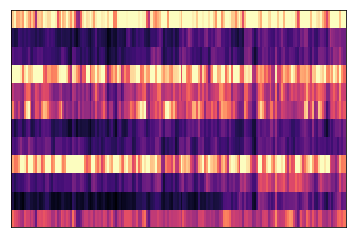

In [4]:
features_nn, labels_nn, folds_nn = get_nn_features(audio, folders)

In [17]:
def process_nn_images(parent_dir,sub_dirs,file_ext="*.png"):
    cgrams = []
    labels = []
    folds = []
    i = 0
    for l, sub_dir in enumerate(sub_dirs):
        print(sub_dir)
        if sub_dir == 'fold5':
            return cgrams, labels, folds
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
#             lib_load, sample_rate = librosa.load(fn)
            label = fn.split('fold')[1].split('-')[1]
            labels.append(label)
            folds.append(sub_dir)
#             stft = np.abs(librosa.stft(lib_load))
#             cgram = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
#             librosa.display.specshow(cgram)
#             plt.savefig(fn + '.png', dpi=10)
            rgba_image = PIL.Image.open(fn)
            rgb_image = rgba_image.convert('RGB')
            cgrams.append(np.array(rgb_image))
            i +=1
            print(f"file {i} processed")
    return cgrams, labels, folds

In [18]:
features_nn, labels_nn, folds_nn = process_nn_images(audio, folders)

fold1
file 1 processed
file 2 processed
file 3 processed
file 4 processed
file 5 processed
file 6 processed
file 7 processed
file 8 processed
file 9 processed
file 10 processed
file 11 processed
file 12 processed
file 13 processed
file 14 processed
file 15 processed
file 16 processed
file 17 processed
file 18 processed
file 19 processed
file 20 processed
file 21 processed
file 22 processed
file 23 processed
file 24 processed
file 25 processed
file 26 processed
file 27 processed
file 28 processed
file 29 processed
file 30 processed
file 31 processed
file 32 processed
file 33 processed
file 34 processed
file 35 processed
file 36 processed
file 37 processed
file 38 processed
file 39 processed
file 40 processed
file 41 processed
file 42 processed
file 43 processed
file 44 processed
file 45 processed
file 46 processed
file 47 processed
file 48 processed
file 49 processed
file 50 processed
file 51 processed
file 52 processed
file 53 processed
file 54 processed
file 55 processed
file 56 proce

file 863 processed
file 864 processed
file 865 processed
file 866 processed
file 867 processed
file 868 processed
file 869 processed
file 870 processed
file 871 processed
file 872 processed
file 873 processed
fold2
file 874 processed
file 875 processed
file 876 processed
file 877 processed
file 878 processed
file 879 processed
file 880 processed
file 881 processed
file 882 processed
file 883 processed
file 884 processed
file 885 processed
file 886 processed
file 887 processed
file 888 processed
file 889 processed
file 890 processed
file 891 processed
file 892 processed
file 893 processed
file 894 processed
file 895 processed
file 896 processed
file 897 processed
file 898 processed
file 899 processed
file 900 processed
file 901 processed
file 902 processed
file 903 processed
file 904 processed
file 905 processed
file 906 processed
file 907 processed
file 908 processed
file 909 processed
file 910 processed
file 911 processed
file 912 processed
file 913 processed
file 914 processed
file 9

file 1293 processed
file 1294 processed
file 1295 processed
file 1296 processed
file 1297 processed
file 1298 processed
file 1299 processed
file 1300 processed
file 1301 processed
file 1302 processed
file 1303 processed
file 1304 processed
file 1305 processed
file 1306 processed
file 1307 processed
file 1308 processed
file 1309 processed
file 1310 processed
file 1311 processed
file 1312 processed
file 1313 processed
file 1314 processed
file 1315 processed
file 1316 processed
file 1317 processed
file 1318 processed
file 1319 processed
file 1320 processed
file 1321 processed
file 1322 processed
file 1323 processed
file 1324 processed
file 1325 processed
file 1326 processed
file 1327 processed
file 1328 processed
file 1329 processed
file 1330 processed
file 1331 processed
file 1332 processed
file 1333 processed
file 1334 processed
file 1335 processed
file 1336 processed
file 1337 processed
file 1338 processed
file 1339 processed
file 1340 processed
file 1341 processed
file 1342 processed


file 1730 processed
file 1731 processed
file 1732 processed
file 1733 processed
file 1734 processed
file 1735 processed
file 1736 processed
file 1737 processed
file 1738 processed
file 1739 processed
file 1740 processed
file 1741 processed
file 1742 processed
file 1743 processed
file 1744 processed
file 1745 processed
file 1746 processed
file 1747 processed
file 1748 processed
file 1749 processed
file 1750 processed
file 1751 processed
file 1752 processed
file 1753 processed
file 1754 processed
file 1755 processed
file 1756 processed
file 1757 processed
file 1758 processed
file 1759 processed
file 1760 processed
file 1761 processed
fold3
file 1762 processed
file 1763 processed
file 1764 processed
file 1765 processed
file 1766 processed
file 1767 processed
file 1768 processed
file 1769 processed
file 1770 processed
file 1771 processed
file 1772 processed
file 1773 processed
file 1774 processed
file 1775 processed
file 1776 processed
file 1777 processed
file 1778 processed
file 1779 proc

file 2157 processed
file 2158 processed
file 2159 processed
file 2160 processed
file 2161 processed
file 2162 processed
file 2163 processed
file 2164 processed
file 2165 processed
file 2166 processed
file 2167 processed
file 2168 processed
file 2169 processed
file 2170 processed
file 2171 processed
file 2172 processed
file 2173 processed
file 2174 processed
file 2175 processed
file 2176 processed
file 2177 processed
file 2178 processed
file 2179 processed
file 2180 processed
file 2181 processed
file 2182 processed
file 2183 processed
file 2184 processed
file 2185 processed
file 2186 processed
file 2187 processed
file 2188 processed
file 2189 processed
file 2190 processed
file 2191 processed
file 2192 processed
file 2193 processed
file 2194 processed
file 2195 processed
file 2196 processed
file 2197 processed
file 2198 processed
file 2199 processed
file 2200 processed
file 2201 processed
file 2202 processed
file 2203 processed
file 2204 processed
file 2205 processed
file 2206 processed


file 2595 processed
file 2596 processed
file 2597 processed
file 2598 processed
file 2599 processed
file 2600 processed
file 2601 processed
file 2602 processed
file 2603 processed
file 2604 processed
file 2605 processed
file 2606 processed
file 2607 processed
file 2608 processed
file 2609 processed
file 2610 processed
file 2611 processed
file 2612 processed
file 2613 processed
file 2614 processed
file 2615 processed
file 2616 processed
file 2617 processed
file 2618 processed
file 2619 processed
file 2620 processed
file 2621 processed
file 2622 processed
file 2623 processed
file 2624 processed
file 2625 processed
file 2626 processed
file 2627 processed
file 2628 processed
file 2629 processed
file 2630 processed
file 2631 processed
file 2632 processed
file 2633 processed
file 2634 processed
file 2635 processed
file 2636 processed
file 2637 processed
file 2638 processed
file 2639 processed
file 2640 processed
file 2641 processed
file 2642 processed
file 2643 processed
file 2644 processed


file 3028 processed
file 3029 processed
file 3030 processed
file 3031 processed
file 3032 processed
file 3033 processed
file 3034 processed
file 3035 processed
file 3036 processed
file 3037 processed
file 3038 processed
file 3039 processed
file 3040 processed
file 3041 processed
file 3042 processed
file 3043 processed
file 3044 processed
file 3045 processed
file 3046 processed
file 3047 processed
file 3048 processed
file 3049 processed
file 3050 processed
file 3051 processed
file 3052 processed
file 3053 processed
file 3054 processed
file 3055 processed
file 3056 processed
file 3057 processed
file 3058 processed
file 3059 processed
file 3060 processed
file 3061 processed
file 3062 processed
file 3063 processed
file 3064 processed
file 3065 processed
file 3066 processed
file 3067 processed
file 3068 processed
file 3069 processed
file 3070 processed
file 3071 processed
file 3072 processed
file 3073 processed
file 3074 processed
file 3075 processed
file 3076 processed
file 3077 processed


file 3461 processed
file 3462 processed
file 3463 processed
file 3464 processed
file 3465 processed
file 3466 processed
file 3467 processed
file 3468 processed
file 3469 processed
file 3470 processed
file 3471 processed
file 3472 processed
file 3473 processed
file 3474 processed
file 3475 processed
file 3476 processed
file 3477 processed
file 3478 processed
file 3479 processed
file 3480 processed
file 3481 processed
file 3482 processed
file 3483 processed
file 3484 processed
file 3485 processed
file 3486 processed
file 3487 processed
file 3488 processed
file 3489 processed
file 3490 processed
file 3491 processed
file 3492 processed
file 3493 processed
file 3494 processed
file 3495 processed
file 3496 processed
file 3497 processed
file 3498 processed
file 3499 processed
file 3500 processed
file 3501 processed
file 3502 processed
file 3503 processed
file 3504 processed
file 3505 processed
file 3506 processed
file 3507 processed
file 3508 processed
file 3509 processed
file 3510 processed


In [21]:
len(features_nn)

3676

In [22]:
import pickle
with open('labels_nn.pkl', 'wb') as f:
    pickle.dump(labels_nn, f)
with open('folds_nn.pkl', 'wb') as f:
    pickle.dump(folds_nn, f)
with open('features_nn.pkl', 'wb') as f:
    pickle.dump(features_nn, f)

## For original Data

In [ ]:
np.savetxt("features.csv", features, delimiter=",")
with open('labels.pkl', 'wb') as f:
    pickle.dump(labels, f)
with open('folds.pkl', 'wb') as f:
    pickle.dump(folds, f)

In [20]:
with open('folds.pkl', 'rb') as f:
    folds = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [39]:
%%capture
with open('labels.csv','wb') as f:
    np.savetxt("labels.csv", labels, delimiter=",", fmt='%u')
sr_folds = pd.Series(folds)
df_fold = pd.DataFrame()
df_fold['fold'] = sr_folds
df_fold.to_csv('folds.csv', index=False, sep=",")

In [7]:
col_list = []
for i in range(1, 21):
    col_list.append('mfcc_mean' + str(i))
for i in range(1, 21):
    col_list.append('mfcc_std' + str(i))
for i in range(1, 8):
    col_list.append('contrast_mean' + str(i))
for i in range(1, 8):
    col_list.append('contrast_std' + str(i))
for i in range(1, 13):
    col_list.append('chroma_mean' + str(i))
for i in range(1, 13):
    col_list.append('chroma_std' + str(i))
col_list.append('rolloff_mean')
col_list.append('rolloff_std')

In [8]:
len(col_list)

80

In [11]:
df = pd.read_csv('./features.csv', names=col_list)

In [12]:
df.head()

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,...,chroma_std5,chroma_std6,chroma_std7,chroma_std8,chroma_std9,chroma_std10,chroma_std11,chroma_std12,rolloff_mean,rolloff_std
0,-131.953600,100.331800,-136.209613,59.544095,-41.002218,18.666155,-29.881801,7.720259,-13.521617,-2.472400,...,0.089103,0.109890,0.082744,0.086488,0.103079,0.091772,0.083112,0.087800,4190.474661,789.164506
1,-212.984794,113.986069,-27.193258,22.607542,0.675223,4.756774,15.624546,15.003598,12.439341,11.358548,...,0.215491,0.213123,0.235415,0.252663,0.193080,0.210450,0.206592,0.201269,3779.575026,698.880879
2,-58.958201,87.640273,-70.350945,-2.818272,-22.161617,-7.152818,-19.660093,-5.150989,-23.104785,-5.124065,...,0.136032,0.116193,0.122456,0.133950,0.129118,0.114089,0.124617,0.122561,4129.396225,773.733583
3,-365.765009,61.840576,8.505344,33.080384,6.873962,-5.327185,-3.849906,-5.238709,-4.314379,-4.959619,...,0.241239,0.240739,0.244525,0.233069,0.224638,0.231544,0.270749,0.263057,5021.219348,1082.168871
4,-84.870940,116.204518,-24.585843,9.107674,6.315533,3.426022,4.600642,4.316528,-0.700944,11.300272,...,0.100473,0.105146,0.112480,0.111136,0.099302,0.101390,0.095279,0.106619,3822.828136,411.186238


In [13]:
sr_labels = pd.Series(labels)

In [14]:
df['label'] = sr_labels

In [15]:
sr_folds = pd.Series(folds)

In [16]:
df['fold'] = sr_folds

In [17]:
df.head()

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,...,chroma_std7,chroma_std8,chroma_std9,chroma_std10,chroma_std11,chroma_std12,rolloff_mean,rolloff_std,label,fold
0,-131.953600,100.331800,-136.209613,59.544095,-41.002218,18.666155,-29.881801,7.720259,-13.521617,-2.472400,...,0.082744,0.086488,0.103079,0.091772,0.083112,0.087800,4190.474661,789.164506,6,fold1
1,-212.984794,113.986069,-27.193258,22.607542,0.675223,4.756774,15.624546,15.003598,12.439341,11.358548,...,0.235415,0.252663,0.193080,0.210450,0.206592,0.201269,3779.575026,698.880879,2,fold1
2,-58.958201,87.640273,-70.350945,-2.818272,-22.161617,-7.152818,-19.660093,-5.150989,-23.104785,-5.124065,...,0.122456,0.133950,0.129118,0.114089,0.124617,0.122561,4129.396225,773.733583,4,fold1
3,-365.765009,61.840576,8.505344,33.080384,6.873962,-5.327185,-3.849906,-5.238709,-4.314379,-4.959619,...,0.244525,0.233069,0.224638,0.231544,0.270749,0.263057,5021.219348,1082.168871,2,fold1
4,-84.870940,116.204518,-24.585843,9.107674,6.315533,3.426022,4.600642,4.316528,-0.700944,11.300272,...,0.112480,0.111136,0.099302,0.101390,0.095279,0.106619,3822.828136,411.186238,7,fold1


In [18]:
with open('raw_df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [16]:
connection_args = {
    'host': '54.183.173.121',  # We are connecting to our _local_ version of psql
    'dbname': 'ubuntu',    # DB that we are connecting to
    'user': 'ubuntu',
    'port': 5432,
}

connection = pg.connect(**connection_args)

In [17]:
query = "SELECT * FROM features;"

pd_sql.read_sql(query, connection)

,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,mfcc_mean5,mfcc_mean6,mfcc_mean7,mfcc_mean8,mfcc_mean9,mfcc_mean10,...,chroma_std5,chroma_std6,chroma_std7,chroma_std8,chroma_std9,chroma_std10,chroma_std11,chroma_std12,rolloff_mean,rolloff_std
0,-131.953600,100.331800,-136.209613,59.544095,-41.002218,18.666155,-29.881801,7.720259,-13.521617,-2.472400,...,0.089103,0.109890,0.082744,0.086488,0.103079,0.091772,0.083112,0.087800,4190.474661,789.164506
1,-212.984794,113.986069,-27.193258,22.607542,0.675223,4.756774,15.624546,15.003598,12.439341,11.358548,...,0.215491,0.213123,0.235415,0.252663,0.193080,0.210450,0.206592,0.201269,3779.575026,698.880879
2,-58.958201,87.640273,-70.350945,-2.818272,-22.161617,-7.152818,-19.660093,-5.150989,-23.104785,-5.124065,...,0.136032,0.116193,0.122456,0.133950,0.129118,0.114089,0.124617,0.122561,4129.396225,773.733583
3,-365.765009,61.840576,8.505344,33.080384,6.873962,-5.327185,-3.849906,-5.238709,-4.314379,-4.959619,...,0.241239,0.240739,0.244525,0.233069,0.224638,0.231544,0.270749,0.263057,5021.219348,1082.168871
4,-84.870940,116.204518,-24.585843,9.107674,6.315533,3.426022,4.600642,4.316528,-0.700944,11.300272,...,0.100473,0.105146,0.112480,0.111136,0.099302,0.101390,0.095279,0.106619,3822.828136,411.186238
5,-293.210491,62.630162,-35.282006,-12.713036,-14.180662,16.396118,18.900044,15.663019,-3.980198,4.763913,...,0.329718,0.328029,0.307995,0.262665,0.282611,0.268966,0.264999,0.281369,3569.408474,753.520349
6,-103.921302,90.244314,-39.394092,20.714833,-23.852438,9.870833,-8.995984,4.334040,-16.106583,-4.249252,...,0.220497,0.198097,0.136942,0.163190,0.187445,0.219975,0.228394,0.181350,4457.933159,932.239877
7,-416.033112,132.882741,-13.828004,35.681555,6.545900,26.133100,14.392525,22.615825,14.790266,14.327495,...,0.114321,0.096342,0.103287,0.111720,0.104242,0.097295,0.104034,0.097374,2600.974446,244.879836
8,-287.956665,206.285161,-108.936250,-45.194916,-47.041701,-21.399980,-37.412829,-21.550088,-33.691980,-15.500254,...,0.095663,0.104318,0.112680,0.081288,0.105097,0.085911,0.093669,0.095887,1653.140100,44.270349
9,-156.362918,119.317915,2.156387,-3.516225,2.812458,10.016456,-3.977992,-0.721998,-3.883083,-9.327974,...,0.176121,0.162487,0.242757,0.228724,0.270284,0.287963,0.280066,0.288612,3646.206083,2151.294068


In [40]:
query = "SELECT * FROM labels;"

pd_sql.read_sql(query, connection)

,label
0,6
1,2
2,4
3,2
4,7
5,8
6,9
7,5
8,5
9,9


In [42]:
query = "SELECT * FROM folds;"

pd_sql.read_sql(query, connection)


,fold
0,fold1
1,fold1
2,fold1
3,fold1
4,fold1
5,fold1
6,fold1
7,fold1
8,fold1
9,fold1
